**Introduction**
In this project, I will go over how political affiliation specifically Democrats,Republicans and Independents feel about Ranked Choice Voting. According to Time Magazine, Ranked-choice voting is an electoral system that involves allowing people to vote for more than one candidate. Instead of normal voting, people will be allowed to have a first, second, and third choice for each position they are voting for.

The focus of the project will be analyzing data to conclude if there is a significant and noticeable different in how Democrats, Republicans, and Independents view ranked-choice voting. If RCV is implemented this would help in swing states and close competitive elections. We will be using a machine learning algorithm for this project which is a  Decision Tree Regression. First we will be using a hypothesis test to statistically test which political affiliation is more prone to RCV. Then we will be using a regression decision tree to test our data to see a true significance.

**Data Description**
This analysis is based on the August 2018 Pulse of the Nation survey, which gathered responses from 800 participants across the United States. The survey purpose is to capture public opinions on a range of political and electoral issues, with particular attention to attitudes toward voting systems. The dataset includes demographic details and insights on topics such as ranked choice voting, political views, and future expectations.

This dataset has multiple categories that can help us understand which factors are influencing and have close ties to RCV. Specifically we will be using political affiliation to identify trends. The key aspects of this analyses will be looking at the information from Democrats, Republicans, and Independents to truly see if political affiliation has a deciding opinion on RCV. The Political Affiliation is categorized into four groups Democrats(1), Republicans(2), Independents(3), Others(0). The Ranked Choice Voting is categorized into three outcomes support(1), oppose(2), undecided(3).

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

cah = pd.read_csv("CAH_PulseoftheNation_FinalProject (1).csv")

In [2]:
cah.head(5)

,Gender,Age,Race,Education,Political Affiliation,Political Leaning,Trump,Finances,Fair Elections,Ranked Choice,Woman President,Universal Healthcare
0,Female,81,White,Some college,Democrat,Liberal,Strongly Disapprove,Not Very Often,No,No,Yes,Yes
1,Male,80,Asian,Some college,Democrat,Moderate,Somewhat Disapprove,Somewhat Often,"Yes, somewhat confident",Yes,Yes,No
2,Female,65,Black,High school or less,Democrat,Moderate,Strongly Disapprove,Somewhat Often,"Yes, somewhat confident",Yes,Yes,No
3,Male,24,Asian,College degree,Independent,Moderate,Strongly Disapprove,Not Very Often,"Yes, somewhat confident",Yes,Yes,No
4,Male,74,White,Graduate degree,Democrat,Liberal,Strongly Disapprove,Not Very Often,"Yes, very confident",Yes,Yes,Yes


In [3]:
cah.describe()

,Age
count,800.000000
mean,59.575000
std,18.242611
min,18.000000
25%,49.750000
50%,62.000000
75%,72.000000
max,99.000000


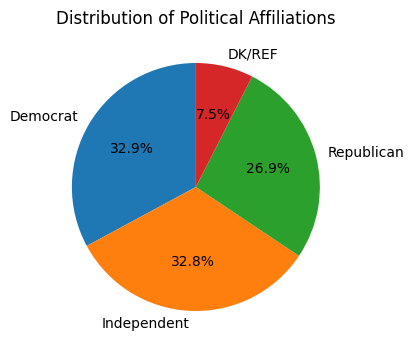

In [4]:
affiliation_counts = cah['Political Affiliation'].value_counts()



# Create a pie chart
affiliation_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(4, 8), startangle=90)
plt.title('Distribution of Political Affiliations')
plt.ylabel('')  # Remove default y-axis label
plt.show()

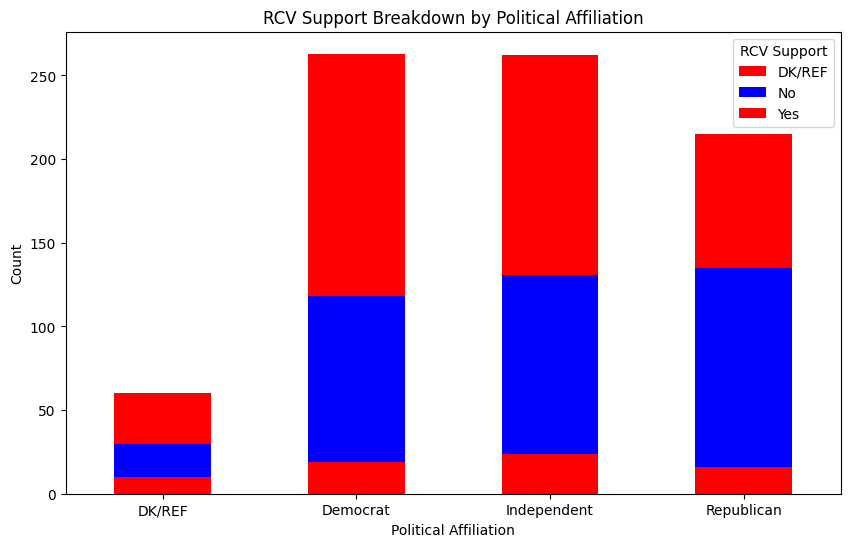

In [5]:
# Group by Political Affiliation and RCV Support
support_breakdown = cah.groupby(['Political Affiliation', 'Ranked Choice']).size().unstack()

# Create a stacked bar chart for a more specific distribution
support_breakdown.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'blue'])
plt.title('RCV Support Breakdown by Political Affiliation')
plt.xlabel('Political Affiliation')
plt.ylabel('Count')
plt.legend(title='RCV Support', loc='upper right')
plt.xticks(rotation=0)
plt.show()

This graph shows the breakdown of support for Ranked Choice Voting (RCV) across political affiliations: Democrats, Republicans, Independents, and a "Don’t Know/Refused" (DK/REF) group. Democrats and Independents demonstrate strong support for RCV, with the majority responding "Yes" and only a smaller portion opposing it. Republicans, on the other hand, are more evenly divided between supporting ("Yes") and opposing ("No") RCV. The DK/REF group is the smallest overall, with most responses being neutral or undecided. Now lets use hypothesis testing to truly see the relationship between ranked choice voting and political affiliation. 

**Statistical Analysis: Hypothesis Test**

*Hypothesis*

Null Hypothesis: There is no association between political affiliation and support for Ranked Choice Voting. Any Observed differences in support are due to random chance.

Alternative Hypothesis: There is an association between political affiliation and support fort Ranked Choice Voting. Observed differences in support are not due to random chance. 

In [6]:
cah_clean = cah.assign(
    democrat = lambda df: df["Political Affiliation"] == "Democrat",
    republican = lambda df: df["Political Affiliation"] == "Republican",
    independent = lambda df: df["Political Affiliation"] == "Independent")

columns_drop = [
    'Education', 'Gender', 'Political Leaning', 'Trump', 
    'Finances', 'Woman President', 'Universal Healthcare', 
    'Fair Elections', 'Race', 'Ranked Choice', 'Political Affiliation']

def convert_political_affiliation(affiliation):
    if affiliation == "Democrat":
        return 1
    elif affiliation == "Republican":
        return 2
    elif affiliation == "Independent":
        return 3
    elif pd.isna(affiliation):
        return None
    else:
        return 0


def convert_rcv(choice):
    if choice == "No":
        return 0
    elif choice == "Yes":
        return 1
    else: 
        return 0

cah_clean = cah.assign(
    political_num = cah["Political Affiliation"].apply(convert_political_affiliation),
    rcv_num = cah["Ranked Choice"].apply(convert_rcv)).drop(columns=columns_drop)

cah_clean.head()
    

,Age,political_num,rcv_num
0,81,1,0
1,80,1,1
2,65,1,1
3,24,3,1
4,74,1,1


**Summarization of Data**

In [7]:
#Group the data in cah_clean DF by 'political_num'
group_summary = cah_clean.groupby('political_num').agg(
    # Calculate proportion of where rcv_num = 1, which is they voted yes for RCV
    support_proportion = ('rcv_num', lambda x: (x==1).mean()),
    # Calculate proporiton of where rcv_num = 0, which is they voted no for RCV
    oppose_proportion = ('rcv_num', lambda x: (x==0).mean()),
    # Count total number of rows in each group
    total_count = ('rcv_num', 'size')
).reset_index() # ensures that group labels are part of DF rather than the index

group_summary


,political_num,support_proportion,oppose_proportion,total_count
0,0,0.500000,0.500000,60
1,1,0.551331,0.448669,263
2,2,0.372093,0.627907,215
3,3,0.500000,0.500000,262


**Permutation Test**

In [8]:
# calculate the mean of 'rcv_num' for each group in the 'political_num' column
observed_means = cah_clean.groupby('political_num')['rcv_num'].mean()
observed_diff =  observed_means.max() - observed_means.min()

observed_diff

np.float64(0.17923777522327355)

**Shuffled Political Affiliation**

In [9]:
permuted_differences = []
n_permutations = 10000 # number of simulations

for i in range(n_permutations):
    # Shuffle political_num column
    shuffled_affiliation = cah_clean['political_num'].sample(frac = 1, replace = False).values
    
    # Assign the shuffled affiliation back to the DataFrame
    permuted_cah = cah_clean.assign(political_num = shuffled_affiliation)

    # Calculate mean supoort per shuffled group
    permuted_means = permuted_cah.groupby('political_num')['rcv_num'].mean()

    # Calculate the difference
    permuted_diff = permuted_means.max() - permuted_means.min()
    permuted_differences.append(permuted_diff)


**Compare Observed to Simulated Differences**

In [10]:
permuted_differences = np.array(permuted_differences)

p_value = (permuted_differences >= observed_diff).mean()

p_value

np.float64(0.0261)

In [11]:
print("Observed Difference:", observed_diff)
print("Max Permuted Difference:", max(permuted_differences))
print("Min Permuted Difference:", min(permuted_differences))
print("P-Value: ", p_value)


Observed Difference: 0.17923777522327355
Max Permuted Difference: 0.3110687022900763
Min Permuted Difference: 0.002804899698206964
P-Value:  0.0261


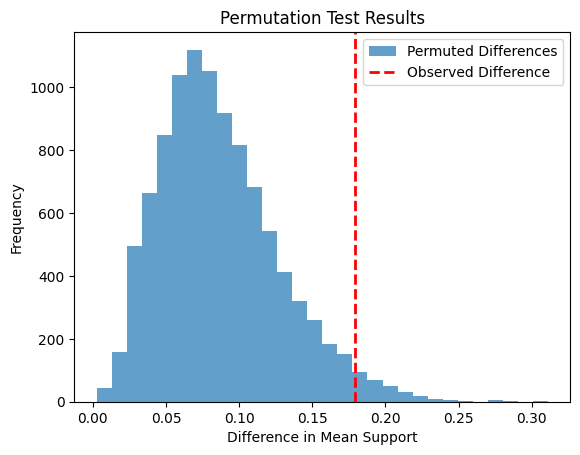

In [12]:
plt.hist(permuted_differences, bins=30, alpha=0.7, label='Permuted Differences')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')

plt.xlabel('Difference in Mean Support')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend()
plt.show()


**Permutation Test Conclusion**
This analysis examined whether there is a meaningful difference in mean support levels (rcv_num) across different political affiliation groups (political_num). The observed difference between the groups with the highest and lowest average support was 0.1792. To test if this difference could simply be due to random chance, a permutation test with 10,000 simulations was conducted. During these simulations, the political group labels were shuffled, and the differences in mean support were recalculated. The largest difference observed during these simulations was 0.2667, and the smallest was 0.0028. The p-value, calculated as 0.0284, indicates how often a difference as large as the observed one occurred in the simulations. Since the p-value is less than 0.05, this result is statistically significant. It suggests that the observed difference in support levels is unlikely to be due to random chance, pointing to a real relationship between political affiliation and support for Ranked Choice Voting.




**Prediction of Decision Tree Model**
The goal of this prediction problem is to identify individuals who are likely to support Ranked Choice Voting. For this analysis, the positive case is defined as individuals with ranked_choice_num = 1, representing those who support Ranked Choice Voting. This is important to understanding which factors drive support and enables a targeted analysis of voting preferences. Political affiliation (political_affiliation_num) was chosen as the primary predictor, as it is a strong categorical indicator of political behavior and alignment with Ranked Choice Voting principles.

To build the prediction model, we used a decision tree classifier to evaluate the relationship between political affiliation and support for Ranked Choice Voting. Multiple models with varying depths were tested to balance complexity and predictive performance. Thresholds for classifying predictions were also adjusted to optimize precision and recall. A depth of 4 and a threshold of 0.4 were selected as the final model parameters, as this configuration provided the best balance between capturing true supporters (recall) and minimizing false positives (precision). The decision tree visualization further validated political affiliation as the most influential factor, with clear splits indicating distinct support patterns across affiliations. These findings underline the appropriateness of the model for the given prediction task.


**Regression Decision Tree Objective**

The goal of the Regression Decision Tree is to predict a 

**Prepare the Data**

In [13]:
cah_clean.head(10)

,Age,political_num,rcv_num
0,81,1,0
1,80,1,1
2,65,1,1
3,24,3,1
4,74,1,1
5,69,1,1
6,41,1,0
7,46,3,1
8,63,1,0
9,60,1,0


In [14]:
from sklearn.model_selection import train_test_split

X = cah_clean.drop(columns=['rcv_num'])  # All columns except 'rcv_num'
y = cah_clean['rcv_num']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [15]:
print(len(X_train))

640


In [16]:
print(len(X_test)) 

160


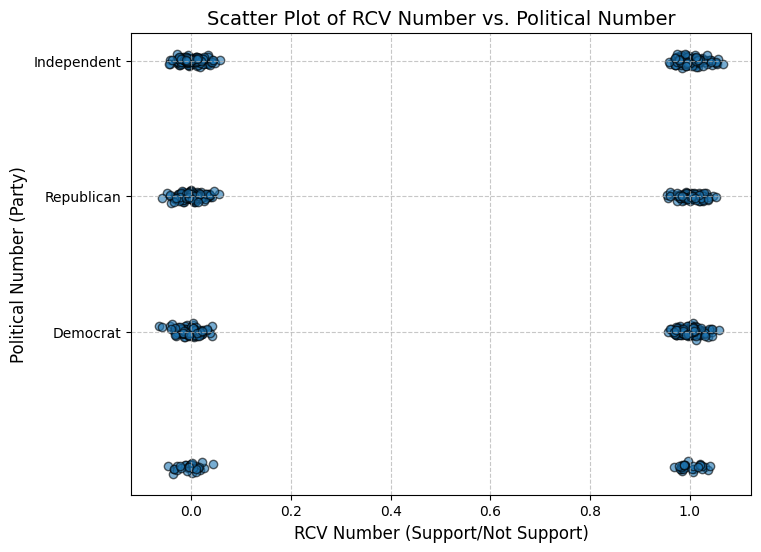

In [17]:

# Adding jitter to discrete variables for better visualization
jitter_x = np.random.normal(0, 0.02, size=len(cah_clean))  # Add slight noise to 'rcv_num'
jitter_y = np.random.normal(0, 0.02, size=len(cah_clean))  # Add slight noise to 'political_num'


# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(cah_clean['rcv_num'] + jitter_x, cah_clean['political_num'] + jitter_y, alpha=0.6, edgecolor='k')

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Scatter Plot of RCV Number vs. Political Number', fontsize=14)
plt.xlabel('RCV Number (Support/Not Support)', fontsize=12)
plt.ylabel('Political Number (Party)', fontsize=12)

# Map numeric categories to labels on the y-axis
plt.yticks([1, 2, 3], ['Democrat', 'Republican', 'Independent'])

# Show the plot
plt.show()



In [18]:
corr_matrix = cah_clean.corr()

corr_matrix["political_num"].sort_values(ascending=False)

political_num    1.000000
rcv_num         -0.040438
Age             -0.108470
Name: political_num, dtype: float64

In [19]:
corr_matrix = cah_clean.corr()

corr_matrix["rcv_num"].sort_values(ascending=False)

rcv_num          1.000000
political_num   -0.040438
Age             -0.203203
Name: rcv_num, dtype: float64

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
tree_regressor = DecisionTreeRegressor(random_state = 42)

In [22]:
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [23]:
y_train_pred = tree_regressor.predict(X_train)

#Calculate Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred) 

In [24]:
print("Training Mean Squared Error: " , train_mse)

Training Mean Squared Error:  0.15589905753968253


In [25]:
print("Training Mean Absolute Error: " , train_mae)

Training Mean Absolute Error:  0.31179811507936506


In [26]:
print("Training R2: " , train_r2)

Training R2:  0.3763976799748633


In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,4,10,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':[1,2,4],
}

grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=42),
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [28]:
-grid_search.best_score_

np.float64(0.25288129671275217)

In [29]:
best_tree_regressor = grid_search.best_estimator_
y_test_pred = best_tree_regressor.predict(X_test)

mean_squared_error(y_test, y_test_pred)


0.24551895200676208

In [30]:
r2_score(y_test, y_test_pred)

-0.00871211224090973

**Build a Pipeline**

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor(random_state = 42))
])



  

In [32]:
# integrate with Grid Search
# Perform Hyperparameter tuning directly within pipeline

param_grid_pipeline = {
    'regressor__max_depth': [3,5,10,None],
    'regressor__min_samples_split': [2,5,10],
    'regressor__min_samples_leaf': [1,2,4],
}

grid_search_pipeline = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_pipeline,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_pipeline.fit(X_train, y_train)




Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [3, 5, 10, None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
print("Best Parameters:", grid_search_pipeline.best_params_)

Best Parameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10}


In [34]:
print("Best Score:", -grid_search_pipeline.best_score_)

Best Score: 0.25288129671275217


In [35]:
best_pipeline = grid_search_pipeline.best_estimator_

y_test_pred = best_pipeline.predict(X_test)

print(f"Pipeline Test Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Pipeline Test R^2: {r2_score(y_test, y_test_pred)}")

Pipeline Test Mean Squared Error: 0.24551895200676208
Pipeline Test R^2: -0.00871211224090973


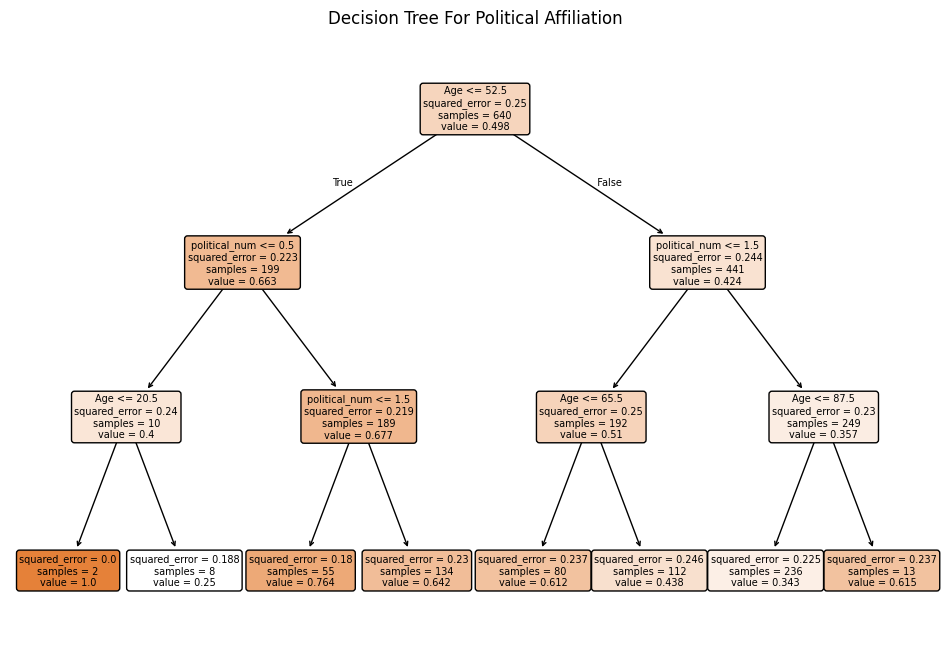

In [36]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plot_tree(best_tree_regressor, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree For Political Affiliation")
plt.show()

**Decision Tree Regression Summary**
The analysis shows a clear connection between political affiliation and support for Ranked Choice Voting (RCV). Through hypothesis testing, we rejected the null hypothesis, finding that the differences in support among Democrats, Republicans, and Independents are not due to random chance but are significantly associated with political affiliation. The decision tree reinforced this by identifying political_num, representing political leanings, as a strong predictor of attitudes toward RCV. For example, individuals with a political_num less than or equal to 0.5 (Democrats or Independents) exhibited higher support, with a mean value of 0.663 and even stronger support in smaller subgroups (a mean value of 0.764 in one branch). On the other hand, individuals with a political_num greater than 1.5 (Republicans) showed lower average support, with values around 0.424 or lower in subgroups. These findings demonstrate that political affiliation plays a major role in shaping how people feel about RCV.